In [ ]:
import torch
from torchdiffeq import odeint
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import time, os, sys
import numpy as np
import pickle
import pandas as pd
from scripts.utils import set_seed
from scripts.ds_class import *
from scripts.homeos import *
from scripts.plotting import *
from scripts.fit_motif import *
from scripts.time_series import *
from scripts.ra import *
from scripts.analysis_tools import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import seaborn as sns

set_seed(313)
exp_folder = 'experiments'
save_dir = 'nd_ra'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
def nd_ra_exp(random_seed=313, dims = [3,4,5,6,7,8,9,10], base_save_dir='nd_ra', summary_df_name='summary_df', ds_motif='ring', layer_sizes = 1*[64]):
    save_dir = os.path.join(exp_folder, base_save_dir, ds_motif)
    os.makedirs(save_dir, exist_ok=True)
    set_seed(random_seed)
    homeo_type = 'node'
    target_layer_sizes = 1*[128]
    homeo_mean = 0.01
    homeo_std = 0.25
    dt=.2
    time_span = torch.tensor([0.0, 2.]) 
    train_ratio = 0.8
    analytic = True
    vf_on_ring_enabled = True #if analytic then not used
    training_pairs = False
    alpha_init = None
    if training_pairs:
        time_span = torch.tensor([0.0, dt])
    simulation_params = {'initial_conditions_mode': 'random', 'number_of_target_trajectories': 50, 'time_span': time_span, 'dt': dt, 'noise_std': .0,
                        'training_pairs': training_pairs, 'margin': 0.1, 'seed': 42, 'train_ratio': train_ratio}
    
    homeo_type = 'node'
    init_type = None

    lr = 0.01
    num_epochs = 1000
    annealing_params = {'dynamic': False, 'initial_std': .0, 'final_std': 0.}
    training_params = {'lr': lr, 'num_epochs': num_epochs, 'annealing_params': annealing_params, 'early_stopping_patience': 1000, "batch_size": 32,
                    'use_inverse_formulation': True}
    
    # all_parameters = {'target_homeo_params': target_homeo_params, 'homeo_params': homeo_params, 'training_params': training_params, 'simulation_params': simulation_params}
    # with open("parameters.pkl", "wb") as f:
    #     pickle.dump(all_parameters, f)
    
    results = []
    for dim_i, dim in enumerate(dims):
        print(f"Dimension: {dim}")

        # generate ring attractor trajectories
        generator_ra = AnalyticalRingAttractor(dim=dim, dt=dt, time_span=time_span) 
        init_conds = prepare_initial_conditions(dim=dim, mode=simulation_params['initial_conditions_mode'], num_points=simulation_params['number_of_target_trajectories'],
                                                 margin=simulation_params['margin'], seed=simulation_params['seed'])
        ra_trajs = generator_ra.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32))

        B = ra_trajs.shape[0]
        n_train = int(train_ratio * B)
        n_test = B - n_train
        target_homeo_params = {'homeo_type': homeo_type, 'dim': dim, 'layer_sizes': target_layer_sizes, 'init_type': 'small', 'activation': nn.ReLU, 'init_mean': homeo_mean, 'init_std': homeo_std}
        target_homeo = build_homeomorphism(target_homeo_params)
        save_homeo_ds_net(target_homeo, f"{save_dir}/target_homeo_{dim}.pth")

        homeo_params = {'homeo_type': homeo_type, 'dim': dim, 'layer_sizes': layer_sizes, 'activation': nn.ReLU, 'init_type': init_type}
        ds_params = {'ds_motif': ds_motif, 'dim':dim, 'dt': dt, 'time_span': time_span, 'analytic': analytic, 'vf_on_ring_enabled': vf_on_ring_enabled, 'alpha_init': alpha_init}

        target_jacobian_norm = jacobian_norm_over_batch(target_homeo, ra_trajs.reshape(-1,dim))

        trajectories_target_full = target_homeo(ra_trajs)
        trajectories_target_full, trajectories_target, mean, std = normalize_scale_pair(trajectories_target_full, simulation_params['training_pairs'])
        np.save(f"{save_dir}/trajectories_target_{dim}.npy", trajectories_target_full.detach().numpy())

        train_set, test_set = random_split(trajectories_target_full, [n_train, n_test])
        trajectories_target_train = trajectories_target[train_set.indices]
        trajectories_target_test = trajectories_target[test_set.indices]

#        trajectories_target_train = trajectories_target_train.detach().numpy()
        #print(trajectories_target_train.shape)
        # plot_trajectories_3d([trajectories_target_train, trajectories_target_test.detach().numpy()], elev=45, azim=90)
        # fig, ax = plt.subplots(figsize=(4, 6))
        # ax.plot(trajectories_target_train[:, :, 0], trajectories_target_train[:, :, 1], 'o', markersize=2, color='blue', alpha=0.5, label='')
        # plt.show()
        # fig, ax = plt.subplots(figsize=(4, 6))
        # ax.plot(trajectories_target_train[:, :, 1], trajectories_target_train[:, :, 2], 'o', markersize=2, color='blue', alpha=0.5, label='')
        # for traj in trajectories_target_train:
        #     ax.plot(np.arange(traj.shape[0]), traj[:, 2], 'o', markersize=2, color='red', alpha=0.5)
        # plt.show()

        target_ra_points = get_homeo_invman(target_homeo, dim=dim)
        target_ra_points = (target_ra_points - mean.detach().numpy()) / std.detach().numpy() 

        homeo = build_homeomorphism(homeo_params)
        source_system_ra = build_ds_motif(**ds_params)
        homeo_ds_net = Homeo_DS_Net(homeo, source_system_ra)
        homeo_ds_net, losses, grad_norms = train_homeo_ds_net_batched(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_train, **training_params)
        homeo_ds_net.eval()
        
        _, _, training_loss = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_train)
        _, _, test_loss = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_test)
        traj_src_np, traj_trans_np, _ = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target)
        
        inv_man = homeo_ds_net.invariant_manifold(100).detach().numpy()
        jac_norm_frobenius = jacobian_norm_over_batch(homeo_ds_net.homeo_network, trajectories_target.reshape(-1,dim), norm_type='fro').detach().numpy()
        jac_norm_spectral = jacobian_norm_over_batch(homeo_ds_net.homeo_network, trajectories_target.reshape(-1,dim), norm_type='spectral').detach().numpy()

        results.append({
            "dim": dim,
            "train_loss": training_loss,
            "test_loss": test_loss,
            "jac_norm_frobenius": jac_norm_frobenius,
            "jac_norm_spectral": jac_norm_spectral,
            "target_jacobian_norm": target_jacobian_norm,
            "losses": losses,
            "grad_norms": grad_norms,
            "inv_man": inv_man,
            "target_ra_points": target_ra_points[0],
        })

        save_homeo_ds_net(homeo_ds_net, f"{save_dir}/homeo_{dim}.pth")
        np.save(f"{save_dir}/traj_motif_transformed_{dim}.npy", traj_trans_np) #save trajectories_motif after transformation 
        np.save(f"{save_dir}/traj_motif_source_{dim}.npy", traj_src_np) #save trajectories_motif directly from the source 

    df = pd.DataFrame(results)
    df.to_pickle(f"{save_dir}/{summary_df_name}.pkl")

In [ ]:
nd_ra_exp(dims=[2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100], base_save_dir='nd_ra', summary_df_name='summary_df_2_100')


In [4]:
save_dir='experiments/nd_ra'
df = pd.read_pickle(f"{save_dir}/summary_df.pkl")

In [5]:
###test models
value_name = 'dim'
for i, row in df.iterrows():
    value = row[value_name]
    all_parameters = pickle.load(open("experiments/homeopert_ring/parameters.pkl", "rb"))
    layer_sizes = all_parameters['homeo_params']['layer_sizes']
    alpha_init = all_parameters['simulation_params']['ds_params']['alpha_init']
    homeo = NODEHomeomorphism(dim=value, layer_sizes=[128], activation=nn.ReLU)        
    dynsys = AnalyticalRingAttractor(dim=value, alpha_init=None, dt=0.2, time_span=torch.tensor([0.0, 2.]))
    homeo_ds_net = load_homeo_ds_net(f"{save_dir}/homeo_{value}.pth", homeo, dynsys)
    homeo_ds_net.eval()
    trajectories_target = np.load(f"{save_dir}/trajectories_target_{row.value}.npy")
    trajectories_target = torch.tensor(trajectories_target, dtype=torch.float32)
    traj_src_np, traj_trans_np, _ = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target)

    np.save(f"{save_dir}/traj_motif_transformed_{value}.npy", traj_trans_np) 
    np.save(f"{save_dir}/traj_motif_source_{value}.npy", traj_src_np) 

RuntimeError: Error(s) in loading state_dict for Homeo_DS_Net:
	Unexpected key(s) in state_dict: "dynamical_system.alpha". 

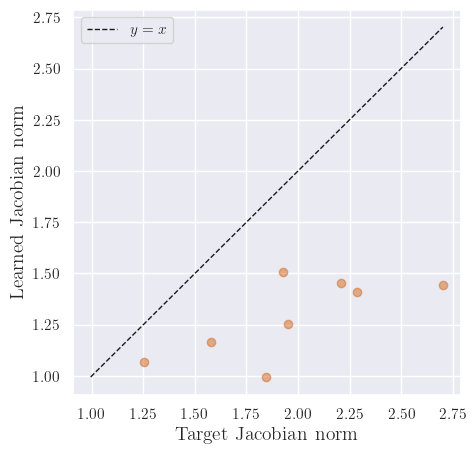

In [6]:
plot_jacobian_norms(df, save_dir)

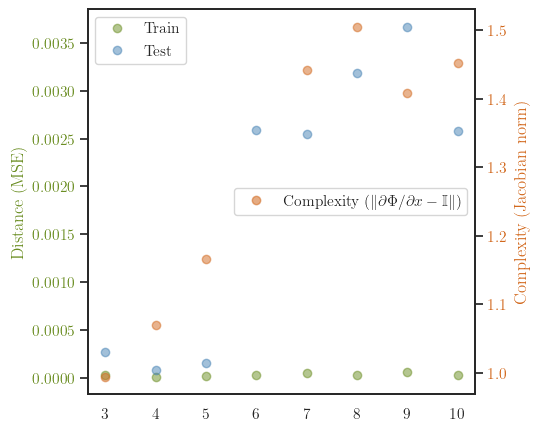

In [12]:
plot_losses_and_jacobian_norms(df, value_name='dim', save_dir=save_dir, save_name='jacobian_norms_error.pdf')

In [13]:
#nd_ra_exp(dims=[20,30,40,50], base_save_dir=save_dir, summary_df_name='summary_df_20_50')

In [18]:
save_dir='experiments/nd_ra/ring'
df = pd.read_pickle(f"{save_dir}/summary_df_20_50.pkl")

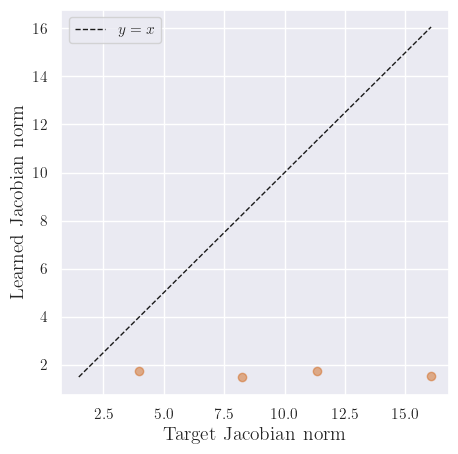

In [20]:
plot_jacobian_norms(df, save_dir, save_name='jacobian_norms_error_20_50.pdf')

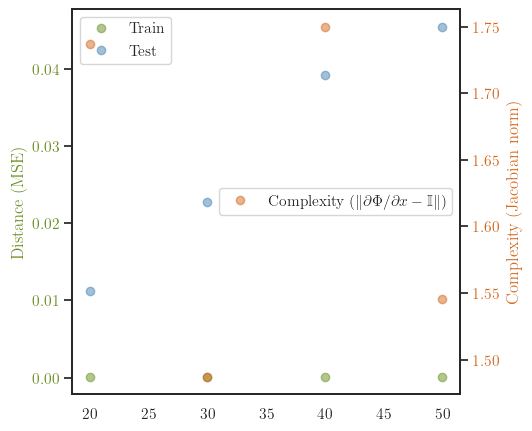

In [21]:
plot_losses_and_jacobian_norms(df, value_name='dim', save_dir=save_dir, save_name='jacobian_norms_error.pdf')

In [ ]:
#nd_ra_exp(dims=[60,70,80,90,100], base_save_dir='nd_ra', summary_df_name='summary_df_60_100')

Dimension: 60
Model saved to experiments\experiments/nd_ra/ring\ring/target_homeo_60.pth
Computing Jacobian norms...
Epoch 0, log(Loss)= -0.4583
Epoch 10, log(Loss)= -0.6253
Epoch 20, log(Loss)= -1.1663
Epoch 30, log(Loss)= -1.4151
Epoch 40, log(Loss)= -1.6933
Epoch 50, log(Loss)= -1.8493
Epoch 60, log(Loss)= -1.9473
Epoch 70, log(Loss)= -2.0318
Epoch 80, log(Loss)= -2.0990
Epoch 90, log(Loss)= -2.1601
Epoch 100, log(Loss)= -2.2019
Epoch 110, log(Loss)= -2.1837
Epoch 120, log(Loss)= -2.2996
Epoch 130, log(Loss)= -2.4072
Epoch 140, log(Loss)= -2.4353
Epoch 150, log(Loss)= -2.5356
Epoch 160, log(Loss)= -2.5546
Epoch 170, log(Loss)= -2.5918
Epoch 180, log(Loss)= -2.5740
Epoch 190, log(Loss)= -2.3728
Epoch 200, log(Loss)= -1.8866
Epoch 210, log(Loss)= -2.1957
Epoch 220, log(Loss)= -2.3931
Epoch 230, log(Loss)= -2.5924
Epoch 240, log(Loss)= -2.6807
Epoch 250, log(Loss)= -2.6572
Epoch 260, log(Loss)= -2.6988
Epoch 270, log(Loss)= -2.8360
Epoch 280, log(Loss)= -2.7128
Epoch 290, log(Loss)= -2

In [28]:
save_dir='experiments/nd_ra/'
df0 = pd.read_pickle(f"{save_dir}/summary_df.pkl")
save_dir='experiments/nd_ra/ring'
df1 = pd.read_pickle(f"{save_dir}/summary_df_20_50.pkl")
df2 = pd.read_pickle(f"{save_dir}/summary_df_60_100.pkl")
df = pd.concat([df0, df1, df2], ignore_index=True)

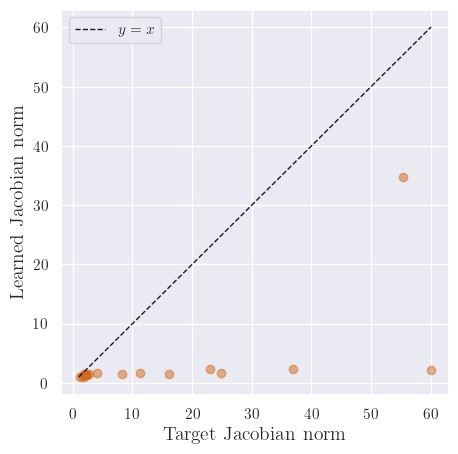

In [31]:
plot_jacobian_norms(df, save_dir, save_name='jacobian_norms_100.pdf')

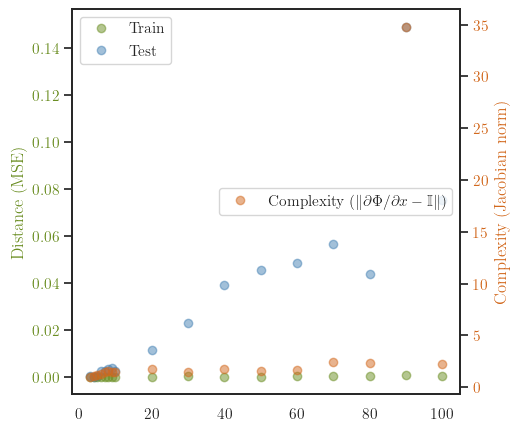

In [30]:
plot_losses_and_jacobian_norms(df, value_name='dim', save_dir=save_dir, save_name='jacobian_norms_error_100.pdf')